#Introduction


Plants are a major source of food for the world population. Plant diseases contribute to production loss, which can be tackled with continuous monitoring. However, manual plant disease monitoring is both laborious and error-prone. Early detection of plant diseases using computer vision and artificial intelligence (AI) can help to reduce the adverse effects of diseases and also overcome the shortcomings of continuous human monitoring. In this study, we propose the use of a deep learning to identify crop deseas through leaf images.

# Problem Statement

Food insecurity, which is a major resultant of plant diseases, is one of the major global problems that humanity faces today. It is projected that, plant diseases account for around 16 percent of global crop yield loss.



* Link to dataset ;https://data.mendeley.com/datasets/tywbtsjrjv/1

* Link to the report; https://docs.google.com/document/d/1LhTxknf-dOz3PkZ9hQgm1At3vowLW1CXiUr81BrcZ3Y/edit#heading=h.98lup5mvdv0

* Link to the slides presentation;https://docs.google.com/presentation/d/1giPrvgXV3pmPdwQ-56DsWGtaZp8c1kSk/edit#slide=id.p1 

#Installing required modules

In [ ]:
!pip install pydot
!pip install graphviz
!pip install flask-ngrok
!pip install keras_segmentation
!pip install keras-resnet
!pip install onnx 
!pip install keras2onnx

# Import the required modules 

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import pickle
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import onnx
import unittest
import keras2onnx
import keras_segmentation
from keras2onnx.proto import keras, is_keras_older_than
from distutils.version import StrictVersion
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from os import listdir
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.optimizers import Adam
from keras.models import Model,Sequential, Input, load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers.convolutional import Conv2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from zipfile import ZipFile
%matplotlib inline

#Load the data:

**Mount the Google Drive to be able to access the ziped file**

Open the link -> copy authorization code -> paste that into the prompt and press "Enter"

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Lets list Folders in our GDrive 

In [ ]:
!ls "/content/gdrive/My Drive/CornDistinct"

 Beans.zip				 CornPlant.ipynb
 Corn_Classification_Deployment.ipynb	 static.zip
 Corn_Classification.ipynb		 templates_version1_.zip
 Corn_Classification_version_two.ipynb	 templates.zip
 Corn_Dataset_Distinct.zip		'Xception function.ipynb'
 Corn_Dataset_fine.zip


# Next we extract files to a folder.

It takes less than 1 minute to unzip 1GB one can use the variation below that suppresses the output. **!unzip gdrive/My\ Drive/data/train.zip > /dev/null**



In [ ]:
!unzip gdrive/My\ Drive/CornDistinct/Corn_Dataset_fine.zip
#!unzip gdrive/My\ Drive/data/train.zip > /dev/null


Archive:  gdrive/My Drive/CornDistinct/Corn_Dataset_fine.zip
  inflating: Corn_Dataset_fine/Corn_Blight/Corn_Blight (1).jpeg  
replace Corn_Dataset_fine/Corn_Blight/Corn_Blight (1).jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Corn_Dataset_fine/Corn_Blight/Corn_Blight (1).jpg  
  inflating: Corn_Dataset_fine/Corn_Blight/Corn_Blight (10).jpg  
  inflating: Corn_Dataset_fine/Corn_Blight/Corn_Blight (100).jpg  
  inflating: Corn_Dataset_fine/Corn_Blight/Corn_Blight (1000).JPG  
  inflating: Corn_Dataset_fine/Corn_Blight/Corn_Blight (1001).JPG  
  inflating: Corn_Dataset_fine/Corn_Blight/Corn_Blight (1002).JPG  
  inflating: Corn_Dataset_fine/Corn_Blight/Corn_Blight (1003).JPG  
  inflating: Corn_Dataset_fine/Corn_Blight/Corn_Blight (1004).JPG  
  inflating: Corn_Dataset_fine/Corn_Blight/Corn_Blight (1005).JPG  
  inflating: Corn_Dataset_fine/Corn_Blight/Corn_Blight (1006).JPG  
  inflating: Corn_Dataset_fine/Corn_Blight/Corn_Blight (1007).JPG  
  inflating: Corn_Dataset_fine/C

In [ ]:
!unzip gdrive/My\ Drive/CornDistinct/templates.zip


Archive:  gdrive/My Drive/CornDistinct/templates.zip
  inflating: templates/index.html    


In [ ]:
!unzip gdrive/My\ Drive/CornDistinct/static.zip


Archive:  gdrive/My Drive/CornDistinct/static.zip
  inflating: static/jquery.js        
  inflating: static/scripts.js       


#Filter out corrupted images From the folder

In [ ]:
import os

num_skipped = 0
for folder_name in ('Corn_Blight','Corn_Common_Rust','Corn_Healthy','Gray_Leaf_Spot'):
    folder_path = os.path.join("Corn_Dataset_fine", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 75 images


#Read in data from the folders

In [ ]:
class_names = ['Corn_Blight','Corn_Common_Rust','Corn_Healthy','Gray_Leaf_Spot']

data_dir = 'Corn_Dataset_fine'
train_dir = os.path.join(data_dir)
train_data = []
for diseaseid_id, disease_name in enumerate(class_names):
    for file in os.listdir(os.path.join(train_dir, disease_name)):
        train_data.append(['{}/{}'.format(disease_name, file), diseaseid_id, disease_name])
        
train= pd.DataFrame(train_data, columns=['File', 'DiseaseID','DiseaseType'])
train.shape

(4113, 3)

#Data description

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4113 entries, 0 to 4112
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   File         4113 non-null   object
 1   DiseaseID    4113 non-null   int64 
 2   DiseaseType  4113 non-null   object
dtypes: int64(1), object(2)
memory usage: 96.5+ KB


#Overview head

In [ ]:
train.head()

File  DiseaseID  DiseaseType
0  Corn_Blight/Corn_Blight (252).JPG          0  Corn_Blight
1  Corn_Blight/Corn_Blight (665).JPG          0  Corn_Blight
2  Corn_Blight/Corn_Blight (850).JPG          0  Corn_Blight
3  Corn_Blight/Corn_Blight (770).JPG          0  Corn_Blight
4  Corn_Blight/Corn_Blight (594).JPG          0  Corn_Blight

#Over view tail

In [ ]:
train.tail()

File  DiseaseID     DiseaseType
4108  Gray_Leaf_Spot/Corn_Gray_Spot (125).jpg          3  Gray_Leaf_Spot
4109  Gray_Leaf_Spot/Corn_Gray_Spot (499).JPG          3  Gray_Leaf_Spot
4110  Gray_Leaf_Spot/Corn_Gray_Spot (249).JPG          3  Gray_Leaf_Spot
4111  Gray_Leaf_Spot/Corn_Gray_Spot (382).JPG          3  Gray_Leaf_Spot
4112  Gray_Leaf_Spot/Corn_Gray_Spot (297).JPG          3  Gray_Leaf_Spot

# Plot a class bar graph


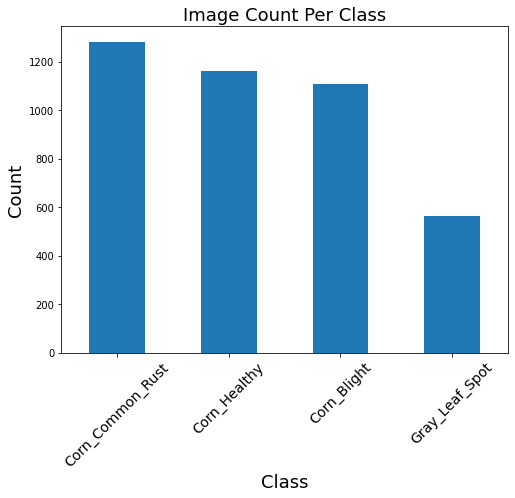

<Figure size 432x288 with 0 Axes>

In [ ]:
train['DiseaseType'].value_counts().plot.bar(figsize=(8,6))
plt.title('Image Count Per Class',size=18)
plt.xlabel('Class',size=18)
plt.xticks(fontsize=14,rotation=45)
plt.ylabel('Count',size=18)
plt.show()
plt.savefig("Classbargraph.jpg", bbox_inches = "tight", dpi = 100)

# Balance the classes
Balance classes by sampling equale sample sizes across all the classes

In [ ]:
train=train.groupby('DiseaseID', group_keys=False).apply(lambda train: train.sample(500))
#Get the number of rows and columns:
train.shape

(2000, 3)

# Generate visalization data set

In [ ]:
image_size = (180, 180)
batch_size = 32

train_dataset= tf.keras.preprocessing.image_dataset_from_directory("Corn_Dataset_fine",validation_split=0.2,subset="training",
    seed=42,image_size=image_size, batch_size=batch_size,)


validation_dataset = tf.keras.preprocessing.image_dataset_from_directory("Corn_Dataset_fine",validation_split=0.2,subset="validation",
    seed=42,image_size=image_size,batch_size=batch_size,)

Found 4113 files belonging to 4 classes.
Using 3291 files for training.
Found 4113 files belonging to 4 classes.
Using 822 files for validation.


#Visualize sample images from each of the classes 

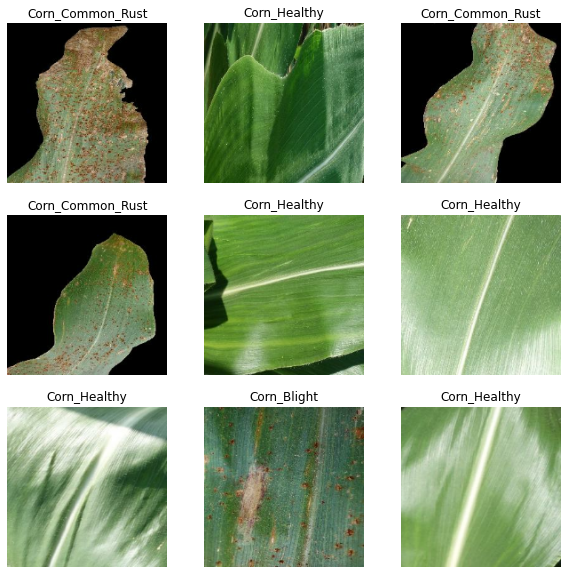

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Data pre-processing via Augmentation 

It helps prevent overfitting, by exposing different aspects of the image to the model,becouse it artificially introduces sample diversity by applying random yet realistic transformations to the training images.It utilizes various transformations, like:

* random rotations,
* horizontal flipping,
* vertical shifts
* zooming,
* shearing.

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("vertical"),
        #layers.experimental.preprocessing.RandomZoom(0.1),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.5),
    ]
)

#Visualize sample augmented image

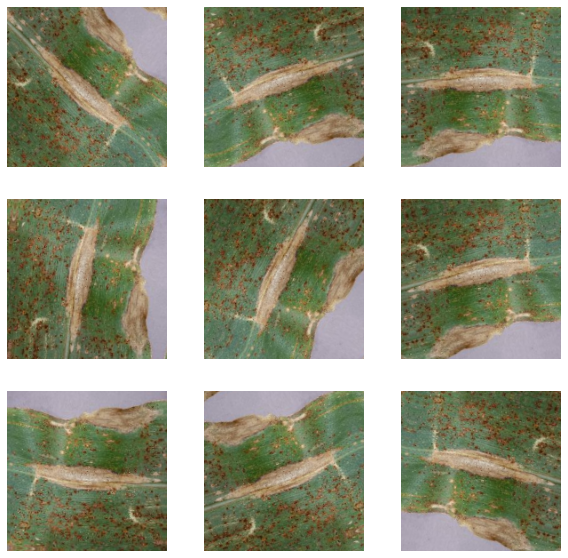

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

#Resize image to target size

In [ ]:
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) # Loading image 
# Resize image to target size
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)
IMAGE_SIZE = 180

#Standardized the data

Though images are already in a standard size **(180x180)**, as they are being yielded as contiguous float32 batches in the dataset. RGB channel values are in the range**[0, 255]** . **This is not ideal for a neural network**; Thus we should seek to make our input values small.By standardizing the values to be in the range **[0, 1]** via a **Rescaling layer** at the start of model.

In [ ]:
train=train.groupby('DiseaseID', group_keys=False).apply(lambda train: train.sample(500))

X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print('Train Shape: {}'.format(X_Train.shape))

2000it [00:09, 219.29it/s]


Train Shape: (2000, 180, 180, 3)


# Split the data set into train and validation 

In [ ]:
SEED=42
BATCH_SIZE = 32
nclasses=4 #train['DiseaseID'].nunique()

Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=nclasses)


# Split the train and validation sets 
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.2, random_state=SEED)

# Display sample from each class

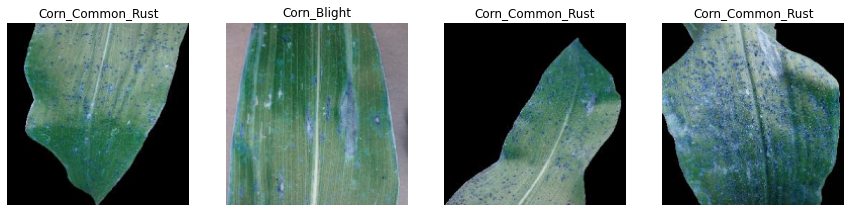

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(15, 15))

for i in range(4):
    ax[i].set_axis_off()
    ax[i].imshow(X_train[i])
    ax[i].set_title(class_names[np.argmax(Y_train[i])])

#Configure parameters

In [ ]:
width=180
height=180
nclasses=4
units = nclasses
input_shape=(width, height, 3)

# Keras Applications

Keras Applications are deep learning models that are made available alongside pre-trained weights. These models can be used for prediction, feature extraction, and fine-tuning.

In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Flatten, Dropout, Input, Lambda, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers.experimental.preprocessing import TextVectorization

#DenseNet121 function
DenseNet121_model=tf.keras.applications.DenseNet121(include_top=False, weights="imagenet",input_tensor=None,input_shape=(width, height, 3),
                      pooling=None, classes=nclasses,) 
#Xception function
Xception_model=tf.keras.applications.Xception(include_top=False, weights="imagenet",input_tensor=None,input_shape=(width, height, 3),
                pooling=None,classes=nclasses,classifier_activation="softmax",)
                


#DenseNet121 function

In [ ]:
#DenseNet121 function

def build_densenet():
    #DenseNet121_model=tf.keras.applications.DenseNet121(include_top=False, weights="imagenet",input_tensor=None,input_shape=(width, height, 3),
                     # pooling=None, classes=nclasses,)
    x=DenseNet121_model.output
    x= GlobalAveragePooling2D()(x)
    x= BatchNormalization()(x)
    x= Dropout(0.5)(x)
    x= Dense(1024,activation='relu')(x) 
    x= Dense(512,activation='relu')(x) 
    x= BatchNormalization()(x)
    x= Dropout(0.5)(x)
    preds=Dense(4,activation='softmax')(x) #FC-layer
      #the 4 afterDense represents the number of classes.
    model=Model(inputs=DenseNet121_model.input,outputs=preds)
    model.summary()

    #compile  model
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
        
    return model

# Train the model

In [ ]:

from keras.applications.densenet import DenseNet121

SIZE=BATCH_SIZE

model = build_densenet()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 186, 186, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 90, 90, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 90, 90, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")



__________________________________________________________________________________________________
conv4_block2_1_bn (BatchNormali (None, 11, 11, 128)  512         conv4_block2_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block2_1_relu (Activation (None, 11, 11, 128)  0           conv4_block2_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block2_2_conv (Conv2D)    (None, 11, 11, 32)   36864       conv4_block2_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block2_concat (Concatenat (None, 11, 11, 320)  0           conv4_block1_concat[0][0]        
                                                                 conv4_block2_2_conv[0][0]        
__________________________________________________________________________________________________
conv4_blo

#Plot the DenseNet121 network Frame work

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.771043 to fit



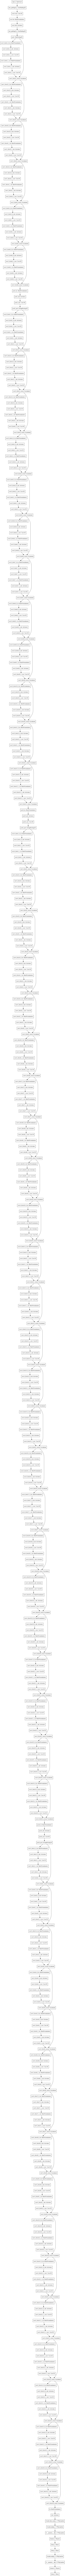

In [ ]:
tf.keras.utils.plot_model(model,'DenseNet121.png')

#Fit the model on data 

In [ ]:
datagen = ImageDataGenerator( rotation_range=360, width_shift_range=0.2, height_shift_range=0.2,zoom_range=0.2, shear_range=0.2, 
                              horizontal_flip=True,vertical_flip=True)



In [ ]:
#Fit the model on data batches
EPOCHS =15

datagen.fit(X_train)

hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy*100,'%'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
50/50 - 838s - loss: 1.5647 - accuracy: 0.3494 - val_loss: 1.2968 - val_accuracy: 0.4450

Epoch 00001: val_loss improved from inf to 1.29680, saving model to model.h5
Epoch 2/15
50/50 - 815s - loss: 0.8188 - accuracy: 0.6681 - val_loss: 0.9510 - val_accuracy: 0.5875

Epoch 00002: val_loss improved from 1.29680 to 0.95099, saving model to model.h5
Epoch 3/15
50/50 - 809s - loss: 0.5443 - accuracy: 0.7906 - val_loss: 0.6580 - val_accuracy: 0.7125

Epoch 00003: val_loss improved from 0.95099 to 0.65798, saving model to model.h5
Epoch 4/15
50/50 - 807s - loss: 0.3805 - accuracy: 0.8569 - val_loss: 0.5658 - val_accuracy: 0.7775

Epoch 00004: val_loss improved from 0.65798 to 0.56578, saving model to model.h5
Epoch 5/15
50/50 - 800s - loss: 0.3193 - accuracy: 0.8831 - val_loss: 0.3576 - val_accuracy: 0.8650

Epoch 00005: val_loss improved from 0.56578 to 0.35762, saving model to model.h5
Epoch 6/15
50/50 - 811s - loss: 0.2804 - accuracy: 0.8975 - val_loss: 0.2981 - val_accuracy: 0

# Evaluating the result

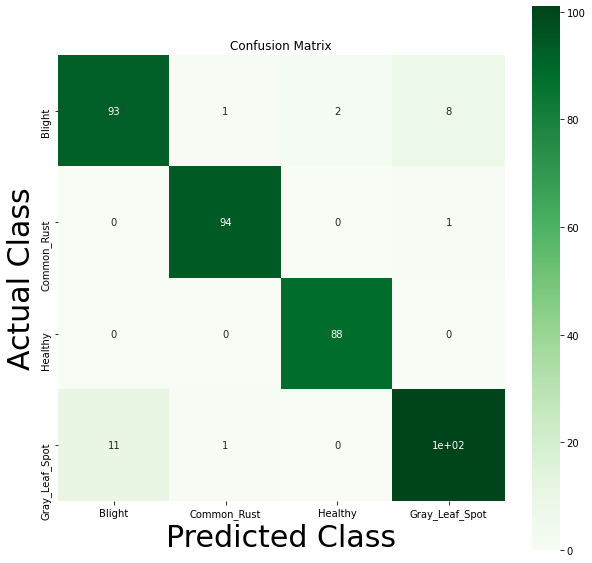

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score, precision_score, recall_score
Y_pred = model.predict(X_val)

Y_pred = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

cm = confusion_matrix(Y_true, Y_pred)
plt.figure(figsize=(10, 10))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=class_names, yticklabels=class_names)
ax.set_ylabel('Actual', fontsize=30)
ax.set_xlabel('Predicted', fontsize=30)
plt.title('Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

 # Accuracy plot and  loss plot

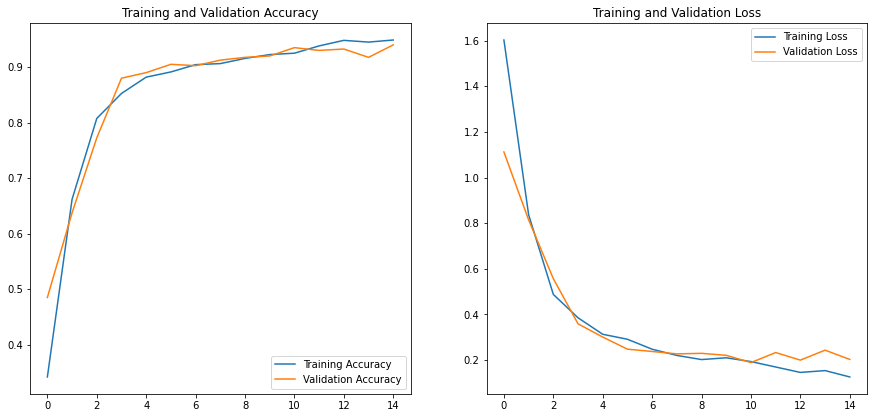

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Disease Classification A

In [ ]:
from skimage import io
from keras.preprocessing import image
from google.colab import files

img = keras.preprocessing.image.load_img('/content/zz1.jpg', target_size=image_size)
show_img=image.load_img('/content/zz1.jpg', grayscale=False, target_size=(180, 180))

img_array = keras.preprocessing.image.img_to_array(img)

img_array = tf.expand_dims(img_array, 0)  # Create batch axis

img_array/=255
class_names =['Corn_Blight','Corn_Common_Rust','Corn_Healthy','Gray_Leaf_Spot']

predictions = model.predict(img_array)

plt.imshow(show_img)

plt.show()

score = predictions[0]

id=np.argmax(score)

n=(100*max(score))


print("This image is %.2f percent" % n,class_names[id] )


NameError: ignored

#Xceptionet function

In [ ]:
#Xceptionet function
import tensorflow as tf
from tensorflow.keras.layers import Input,Dense,Conv2D,Add
from tensorflow.keras.layers import SeparableConv2D,ReLU
from tensorflow.keras.layers import BatchNormalization,MaxPool2D
from tensorflow.keras.layers import GlobalAvgPool2D
from tensorflow.keras import Model
# creating the Conv-Batch Norm block

def conv_bn(x, filters, kernel_size, strides=1):
    
    x = Conv2D(filters=filters, 
               kernel_size = kernel_size, 
               strides=strides, 
               padding = 'same', 
               use_bias = False)(x)
    x = BatchNormalization()(x)
    return x
# creating separableConv-Batch Norm block

def sep_bn(x, filters, kernel_size, strides=1):
    
    x = SeparableConv2D(filters=filters, 
                        kernel_size = kernel_size, 
                        strides=strides, 
                        padding = 'same', 
                        use_bias = False)(x)
    x = BatchNormalization()(x)
    return x
# entry flow

def entry_flow(x):
    
    x = conv_bn(x, filters =32, kernel_size =3, strides=2)
    x = ReLU()(x)
    x = conv_bn(x, filters =64, kernel_size =3, strides=1)
    tensor = ReLU()(x)
    
    x = sep_bn(tensor, filters = 128, kernel_size =3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 128, kernel_size =3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=128, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =256, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=256, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters =728, kernel_size=3)
    x = MaxPool2D(pool_size=3, strides=2, padding = 'same')(x)
    
    tensor = conv_bn(tensor, filters=728, kernel_size = 1,strides=2)
    x = Add()([tensor,x])
    return x
# middle flow

def middle_flow(tensor):
    
    for _ in range(8):
        x = ReLU()(tensor)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        x = sep_bn(x, filters = 728, kernel_size = 3)
        x = ReLU()(x)
        tensor = Add()([tensor,x])
        
    return tensor
# exit flow

def exit_flow(tensor):
    
    x = ReLU()(tensor)
    x = sep_bn(x, filters = 728,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 1024,  kernel_size=3)
    x = MaxPool2D(pool_size = 3, strides = 2, padding ='same')(x)
    
    tensor = conv_bn(tensor, filters =1024, kernel_size=1, strides =2)
    x = Add()([tensor,x])
    
    x = sep_bn(x, filters = 1536,  kernel_size=3)
    x = ReLU()(x)
    x = sep_bn(x, filters = 2048,  kernel_size=3)
    x = GlobalAvgPool2D()(x)
    
    x = Dense (units =4, activation = 'softmax')(x)
    
    return x


In [ ]:

#Xception function
def build_Xception():
    input = Input(shape = input_shape)
    x = entry_flow(input)
    x = middle_flow(x)
    output = exit_flow(x)

    model = Model (inputs=input, outputs=output)
    #compile  model
    optimizer = Adam(lr=0.002, beta_1=0.9, beta_2=0.999, epsilon=0.1, decay=0.0)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
        
    return model

In [ ]:
SIZE=BATCH_SIZE

model =build_Xception()
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)



Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 180, 180, 3) 0                                            
__________________________________________________________________________________________________
conv2d_98 (Conv2D)              (None, 90, 90, 32)   864         input_8[0][0]                    
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, 90, 90, 32)   128         conv2d_98[0][0]                  
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 90, 90, 32)   0           batch_normalization_98[0][0]     
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


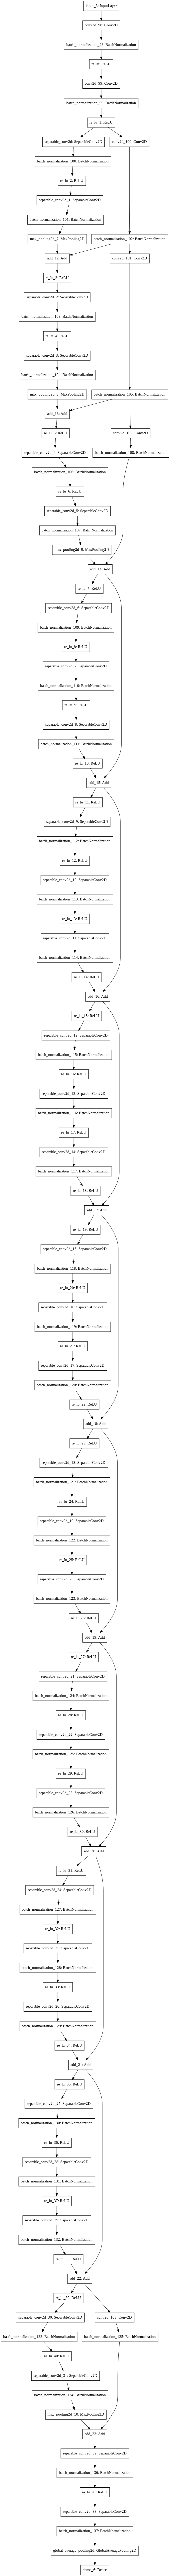

In [ ]:
tf.keras.utils.plot_model(model, 'Xceptionet.png')

In [ ]:
datagen = ImageDataGenerator( rotation_range=360, width_shift_range=0.2, height_shift_range=0.2,zoom_range=0.2, shear_range=0.2, 
                              horizontal_flip=True,vertical_flip=True)



In [ ]:
#Fit the model on data batches
EPOCHS =15

datagen.fit(X_train)

hist = model.fit_generator(datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
               steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
               epochs=EPOCHS,
               verbose=2,
               callbacks=[annealer, checkpoint],
               validation_data=(X_val, Y_val))

final_loss, final_accuracy = model.evaluate(X_val, Y_val)
print('Final Loss: {}, Final Accuracy: {}'.format(final_loss, final_accuracy*100,'%'))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
50/50 - 33s - loss: 0.8397 - accuracy: 0.6806 - val_loss: 1.3849 - val_accuracy: 0.2825

Epoch 00001: val_loss improved from inf to 1.38486, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
50/50 - 24s - loss: 0.5019 - accuracy: 0.7819 - val_loss: 1.3831 - val_accuracy: 0.2825

Epoch 00002: val_loss improved from 1.38486 to 1.38308, saving model to model.h5
Epoch 3/15
50/50 - 23s - loss: 0.4382 - accuracy: 0.8206 - val_loss: 1.3818 - val_accuracy: 0.2825

Epoch 00003: val_loss improved from 1.38308 to 1.38183, saving model to model.h5
Epoch 4/15
50/50 - 23s - loss: 0.3945 - accuracy: 0.8350 - val_loss: 1.3810 - val_accuracy: 0.2825

Epoch 00004: val_loss improved from 1.38183 to 1.38100, saving model to model.h5
Epoch 5/15
50/50 - 24s - loss: 0.3872 - accuracy: 0.8325 - val_loss: 1.3812 - val_accuracy: 0.2825

Epoch 00005: val_loss did not improve from 1.38100
Epoch 6/15
50/50 - 24s - loss: 0.3553 - accuracy: 0.8469 - val_loss: 1.3788 - val_accuracy: 0.2600

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 00006: val_loss improved from 1.38100 to 1.37881, saving model to model.h5
Epoch 7/15
50/50 - 23s - loss: 0.3224 - accu

 # Accuracy plot and  loss plot

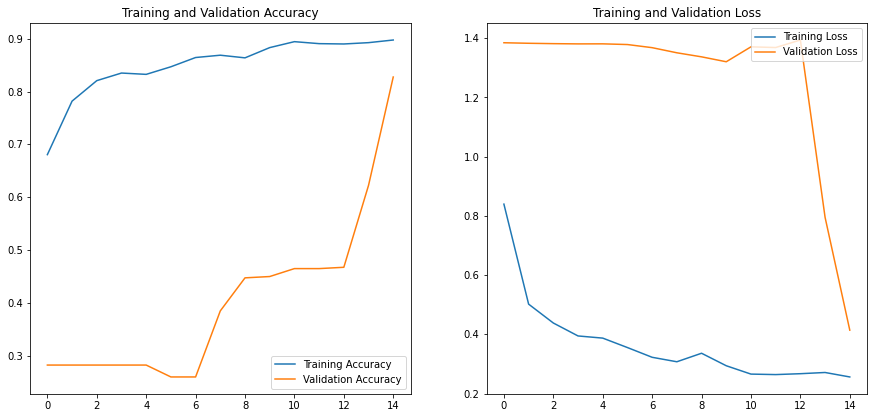

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(EPOCHS)

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

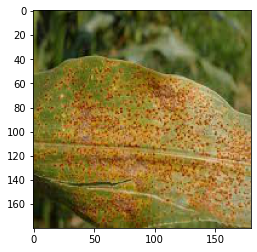

This image is 50.96 percent Corn_Common_Rust


In [ ]:
from skimage import io
from keras.preprocessing import image
from google.colab import files

img = keras.preprocessing.image.load_img('/content/rusted_corn_leaf.jpg', target_size=image_size)
show_img=image.load_img('/content/rusted_corn_leaf.jpg', grayscale=False, target_size=(180, 180))

img_array = keras.preprocessing.image.img_to_array(img)

img_array = tf.expand_dims(img_array, 0)  # Create batch axis

img_array/=255
class_names =['Corn_Blight','Corn_Common_Rust','Corn_Healthy','Gray_Leaf_Spot']

predictions = model.predict(img_array)

plt.imshow(show_img)

plt.show()

score = predictions[0]

id=np.argmax(score)

n=(100*max(score))


print("This image is %.2f percent" % n,class_names[id] )


#Model Deployment

upload the model and this zip file in our Google Colab

In [ ]:
#from google.colab import files
#uploaded = files.upload()

We Create a new directory named static which contains an images directory for storing the images.

In [ ]:
!mkdir static

!mkdir /content/static/images

mkdir: cannot create directory ‘static’: File exists


In [ ]:
import flask
from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
import os
from keras.models import load_model 
from keras.preprocessing import image
import numpy as np

ModuleNotFoundError: ignored

Load our pre-trained model and configure the images folder

In [ ]:

app = Flask(__name__)
run_with_ngrok(app) 

image_folder = os.path.join('static', 'images')
app.config["UPLOAD_FOLDER"] = image_folder
model = load_model('model.h5')

After that, we will call route with the methods ‘GET’ and define a home function to get the image from the user which is our input.

In [ ]:
@app.route('/', methods=['GET'])
def home():
  return render_template('index.html')

makes the predictions using the model and render the output. 



In [ ]:

@app.route('/', methods=['POST'])
def predict():
  from skimage import io
  from keras.preprocessing import image
  from google.colab import files
  import tensorflow as tf
  # predicting images
  imagefile = request.files['imagefile']
  image_path = './static/images/' + imagefile.filename 
  imagefile.save(image_path)

  #img = image.load_img(image_path, grayscale=False,target_size=(180,180))
  img = keras.preprocessing.image.load_img(image_path, target_size=(180,180))


  img_array = keras.preprocessing.image.img_to_array(img)

  img_array = tf.expand_dims(img_array, 0)  # Create batch axis

  img_array/=255
  class_names =['Corn_Blight','Corn_Common_Rust','Corn_Healthy','Gray_Leaf_Spot']

  predictions = model.predict(img_array)

  score = predictions[0]

  id=np.argmax(score)

  n=(100*max(score))

  pic = os.path.join(app.config['UPLOAD_FOLDER'], imagefile.filename)

  return render_template('index.html', user_image=pic, prediction_text='This image is {} % {}'.format(n,class_names[id]))
    


In [ ]:
if __name__=='__main__':
       app.run()

#Conclusion

The project was successfully in building a classification model that can correctly classify corn leaf disease. The model could be scaled to cover more crops.Further, it was observed that DenseNet121 performed better than the  Xception model.
